***
# Association between kids' screen time and their mental health

Minh-Khang Vu

## Question

Recently, I came across the article [There’s Worrying New Research About Kids’ Screen Time and Their Mental Health](http://time.com/5437607/smartphones-teens-mental-health/) and became interested in this topic. In the article, the author of the study found "a clear and strong association" between more screen time and lower wellbeing. She expressed a concern that digital technology might have a negative effect on health and wellbeing of children. However, there might not be a direct correlation between kids' screen time and mental health as other researchers argued that anxious and depressed kids tend to spend more time using screens. Whether screen time affects children's wellbeing is questionable, but this study still provides an important insight into children's health and wellbeing.

In this project, the main question I'd like to answer is **How does children's screen time relate to their mental health?** I used the Census Bureau’s 2017 [National Survey of Children’s Health (NSCH)](https://www.census.gov/data/datasets/2017/demo/nsch/nsch2017.html) to explore the relationship between children's screen time and their mental health. Reading the article, I couldn't find any useful statistics to support that relationship. Therefore, I'd like to explore whether this is true and present the results with clear visualizations. Besides the main question, I also experimented with other variables and found out that how often a family has meals together is also associated with their kids' screen time and mental health.

#### About NSCH 2017 Data
The data in this Notebook is from the National Survey of Children's Health (NSCH) in 2017. The data provides the screen time usage level of children under 18 as well as the anxiety level, `anxiety_lvl`, and depression level, `depression_lvl`, all of which were answered by their parents. Two variables related to screen time usage are time spent on computers and TV daily (`cmputr_time` & `tv_time`), and I will leave them as they are instead of combining them because the use of computers and TV may vary across age. In this project, I will also use the variable `family_meals` which indicates how often their family has meals together.

 The data was processed and cleaned using this notebook: https://github.com/minhkhang1795/ThinkStats2/blob/master/project1/data/datacleaning.ipynb. Please refer to the notebook to learn more about how I processed the data and about its Guidelines for Data Use.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

from project1_utils import * # My utility

In [3]:
df = pd.read_pickle('data/nsch_2017_topical_clean.pkl')
df.head()

,sc_age_years,cmputr_time,tv_time,anxiety_lvl,depression_lvl,need_treatment,family_meals,homework_unfinished
0,0,0.0,0.0,0.0,0.0,3.0,1.0,NaN
1,13,3.0,2.0,0.0,0.0,3.0,2.0,1.0
2,15,3.0,1.0,0.0,0.0,3.0,2.0,2.0
3,9,4.0,4.0,0.0,0.0,3.0,1.0,1.0
4,8,1.0,2.0,0.0,0.0,3.0,2.0,1.0


***
***
## Methodology & Results

First, I'll plot the screen times (from now on, screen times will refer to both the computer and TV times) versus the percentage of kids with anxiety and with depression in order to see if there is any relationship among them. In these plots, I'll also add a shaded region to illustrate 90% Confidence Interval of the percentages.

### 1. Screen times vs Anxiety/Depression level
Variables used: `cmputr_time`, `tv_time`, `anxiety_lvl`, `depression_lvl`

To make this plot, I'll categorize the data into bins of screen time level, from 0 (None) to 5 (>4 hrs daily). In each bins, I will calculate the percentage of kids having anxiety or depression problems recently. In the `anxiety_lvl` and `depression_lvl` data series, zeros indicates that the kid does not have that condition recently, while positive values indicate the severity of the condition. For now, we just want to know whether or not the kid has any anxiety/depression problem.

As an example, I'll start with `cmputr_time` versus `anxiety_lvl`:

In [4]:
# Categorize data into bins
dataSeries = df['cmputr_time']
bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
indices = np.digitize(dataSeries, bins)
groups = df.groupby(indices)

In [5]:
# For each binned group, calculate the percentage of kids having anxiety
perc = [] # Percentage list
for i, group in groups:
    total = group['anxiety_lvl'].count()
    positives = group['anxiety_lvl'][group['anxiety_lvl'] > 0].count() # Having anxiety/depression
    perc.append(positives/total * 100)
perc

[2.5418474891506513,
 5.117168818747011,
 7.533946561541831,
 8.913890090869753,
 12.620912022109627,
 15.96607669616519]

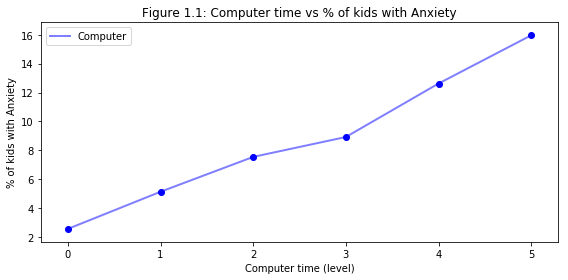

In [6]:
# Plot Computer time vs Anxiety Level
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
ax.scatter(bins, perc, linewidth=1, color='blue', alpha=1)
decorate(title='Figure 1.1: Computer time vs % of kids with Anxiety', xlabel='Computer time (level)', ylabel='% of kids with Anxiety')

As we can see in the Figure 1.1 above, computer time level and % of kids with Anxiety has a linear relationship. In this figure, we can see that about 16% of kids spending 4 hours or more with computers have some anxiety problems.

Next, I will find the 90% CI of the line above.

In [7]:
# Take a sample from the data (with replacement) 
# and run many iterations to find estimates at each percentage points.
t = [] # List of estimates
for _ in range(101):
    sample = thinkstats2.ResampleRows(df)
    # This function groups the DataFrame into bins of cmputr_time
    bins, groups = GroupToBins(sample, 'cmputr_time', bin_size=1)
    # For each binned group, calculate the percentage of kids having anxiety/depression
    estimates = []
    for i, group in groups:
        total = group['anxiety_lvl'].count()
        positives = group['anxiety_lvl'][group['anxiety_lvl'] > 0].count() # Having anxiety/depression
        estimates.append(positives/total * 100)
    
    t.append(estimates)

# Now for each list of estimates, find the 90% CI
estimatesList = np.array(t).transpose()
cis = []
for estimates in estimatesList:
    ci = ComputeCI(estimates)
    cis.append(ci)
cis = np.array(cis).transpose()

Now, re-plot the results with 90% CI. The 90% CI of the rightmost tail (for kids spending > 4hrs) seems to have a wider range, meaning that this estimate has higher uncertainty.

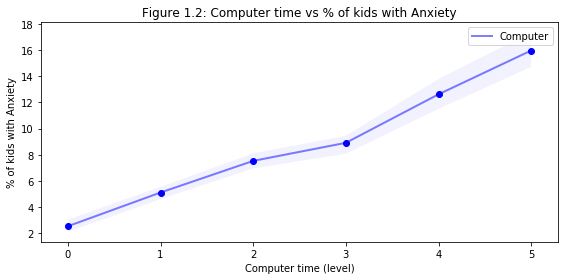

In [8]:
# Plot Computer time vs Anxiety Level with 90% CI
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
ax.scatter(bins, perc, linewidth=1, color='blue', alpha=1)
ax.fill_between(bins, cis[0], cis[1], where=cis[0] <= cis[1], 
                    facecolor='blue', alpha=0.05, interpolate=True)
decorate(title='Figure 1.2: Computer time vs % of kids with Anxiety', xlabel='Computer time (level)', ylabel='% of kids with Anxiety')

I'll wrap up everything into functions and store them in the `project_utils.py` library. The codeblock below plots the depression level versus screen times as well. 

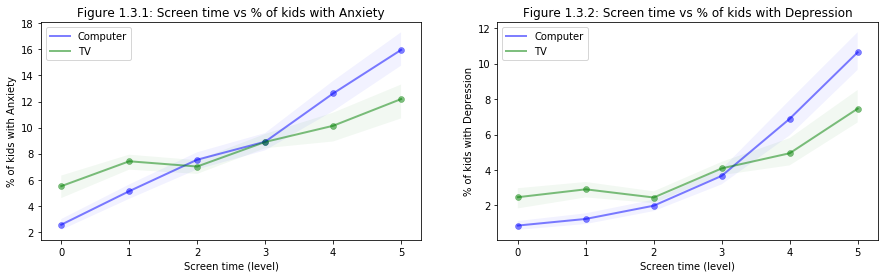

In [9]:
variables = ['anxiety_lvl', 'depression_lvl']
labels = ['Anxiety', 'Depression']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculatePercentages(GroupToBins(df, group_name='cmputr_time'), variable=variables[i])
    bins_tv, perc_tv = CalculatePercentages(GroupToBins(df, group_name='tv_time'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculatePercentages, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='tv_time', Operation=CalculatePercentages, variable=variables[i]))
    # Computer time
    ax[i].plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
    ax[i].scatter(bins, perc, linewidth=0.5, color='blue', alpha=0.5)
    ax[i].fill_between(bins, cis[0], cis[1], where=cis[0] <= cis[1], 
                    facecolor='blue', alpha=0.05, interpolate=True)
    # TV time
    ax[i].plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
    ax[i].scatter(bins_tv, perc_tv, linewidth=0.5, color='green', alpha=0.5)
    ax[i].fill_between(bins, cis_tv[0], cis_tv[1], where=cis_tv[0] <= cis_tv[1], 
                    facecolor='green', alpha=0.05, interpolate=True)
    ax[i].legend(loc='best')
    ax[i].title.set_text("Figure 1.3." + str(i + 1) +": Screen time vs % of kids with " + labels[i])
    ax[i].set(xlabel='Screen time (level)', ylabel='% of kids with ' + labels[i])

In general, screen times has a strong linear relationship with anxiety and depression levels. The computers usage line has a steeper slope than the TV usage line, which indicates that computers usage might have a stronger relationship with anxiety/depression levels than the TV usage.

#### Proportion of percentages

There is another thing I want to find out in this relationship: what is the proportion of kids having mental problems in the low screen time level to those in the high screen time level. First, let's define the low and high screen time levels as follows:
- Low screen time level: spending less than 3 hours a day (level 0 - 2)
- High screen time level: spending more than 3 hours (level 3 - 5)

The process is nearly the same as what I just did above. However, instead of grouping the data into bins of size 1 (range of level of each bin is 1), I will group them into bins of size 3. Below are the results:

In [10]:
groupResults = GroupToBins(df, group_name='cmputr_time', bin_size=3)
perc, proportionalPerc = CalculateProportionalPercentage(groupResults, variable='depression_lvl')
print("Low screen time level: " + str(perc[0]) + "% having depression.")
print("Hight screen time level: " + str(perc[1]) + "% having depression.")
print("Proportion of percentage of kids having depression (high/low):", proportionalPerc)

Low screen time level: 1.4259506337558372% having depression.
Hight screen time level: 6.39168765743073% having depression.
Proportion of percentage of kids having depression (high/low): 4.482404584088265


The 4.48 value indicates that children who spend 3 hours or more daily using computers are four times more likely to experience depression. I did the similar analysis with the Anxiety Level and found out that children are twice more likely to have an anxiety problem if they spend too much time using computers. Below are the 90% CI for this estimate:

In [11]:
estimates = SamplingDistributions(df, group_name='cmputr_time', Operation=CalculateProportionalPercentage, 
                                  bin_size=3, variable='depression_lvl')
cis = ComputeCI(estimates)
cis

(3.92112025927684, 5.03360563615207)

#### p-values of the effects

Next, let's see if these effects (four/two times more likely to experience depression/anxiety) is due to chance. I'll calculate the p-value assuming that time spent on computers does not have any effect on the depression/anxiety levels. Below is the Hypothesis Test.

In [12]:
class ProportionalTest():
    def __init__(self, data, group_name='cmputr_time', variable='depression_lvl'):
        self.data = df.dropna(subset=[group_name, variable])
        self.group_name = group_name
        self.variable = variable
        self.actual = self.TestStatistic(data)
        
    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters
        
    def TestStatistic(self, data):
        # Calculate Proportional Percentage
        groupResults = GroupToBins(data, self.group_name, bin_size=3)
        _, perc = CalculatePercentages(groupResults, self.variable)
        return perc[1]/perc[0]

    def RunModel(self):
        # Copy the data frame
        shuffled_data = self.data.copy()
        # Permutate the rows of the depression_lvl column on the copy
        shuffled_column = np.random.permutation(shuffled_data.depression_lvl) 
        shuffled_data[self.variable] = shuffled_column
        return shuffled_data

The results are zeros for both effects, which means that they are statistically significant.

In [13]:
# p-value of the effect: four times more likely to experience depression
p_test = ProportionalTest(df, group_name='cmputr_time', variable='depression_lvl')
p_test.PValue()

0.0

In [14]:
# p-value of the effect: two times more likely to experience anxiety
p_test = ProportionalTest(df, group_name='cmputr_time', variable='anxiety_lvl')
p_test.PValue()

0.0

### 2. Gauging the anxiety/depression levels

Currently, we have not taken into account the anxiety/depression severity level. In this section, I want to see if a child is having an anxiety or depression, how bad it could be? 

I'll plot the screen time versus the severity. The method is nearly the same as above. The only difference is that we only look at children who have anxiety/depression and we will take the mean score of the anxiety/depression level. According to the codebook, the scores are as follows:
- 1 = Mild
- 2 = Moderate
- 3 = Severe

In [15]:
# Operation on each group: calculate mean of kids having anxiety/depression
def CalculateMeans(groupResults, variable='depression_lvl'):
    bins, groups = groupResults
    means = [] # Mean score of anxiety/depression level
    for i, group in groups:
        positives = group[variable][group[variable] > 0] # Only consider kids having anxiety/depression
        means.append(positives.mean())
    return np.array(bins), np.array(means)

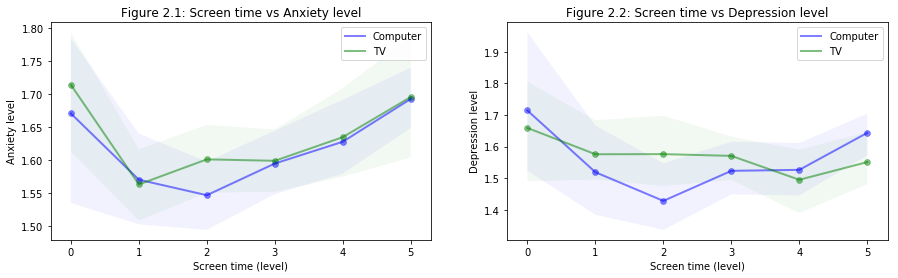

In [16]:
variables = ['anxiety_lvl', 'depression_lvl']
labels = ['Anxiety level', 'Depression level']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculateMeans(GroupToBins(df, group_name='cmputr_time'), variable=variables[i])
    bins_tv, perc_tv = CalculateMeans(GroupToBins(df, group_name='tv_time'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculateMeans, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='tv_time', Operation=CalculateMeans, variable=variables[i]))
    # Computer time
    ax[i].plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
    ax[i].scatter(bins, perc, linewidth=0.5, color='blue', alpha=0.5)
    ax[i].fill_between(bins, cis[0], cis[1], where=cis[0] <= cis[1], 
                    facecolor='blue', alpha=0.05, interpolate=True)
    # TV time
    ax[i].plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
    ax[i].scatter(bins_tv, perc_tv, linewidth=0.5, color='green', alpha=0.5)
    ax[i].fill_between(bins, cis_tv[0], cis_tv[1], where=cis_tv[0] <= cis_tv[1], 
                    facecolor='green', alpha=0.05, interpolate=True)
    ax[i].legend(loc='best')
    ax[i].title.set_text("Figure 2." + str(i + 1) +": Screen time vs " + labels[i])
    ax[i].set(xlabel='Screen time (level)', ylabel=labels[i])

In [24]:
# Operation on each group: calculate mean of kids having anxiety/depression
def CalculateMeans(groupResults, variable='depression_lvl'):
    bins, groups = groupResults
    means = [] # Mean score of anxiety/depression level
    for i, group in groups:
        positives = group[variable] # Only consider kids having anxiety/depression
        means.append(positives.mean())
    return np.array(bins), np.array(means)

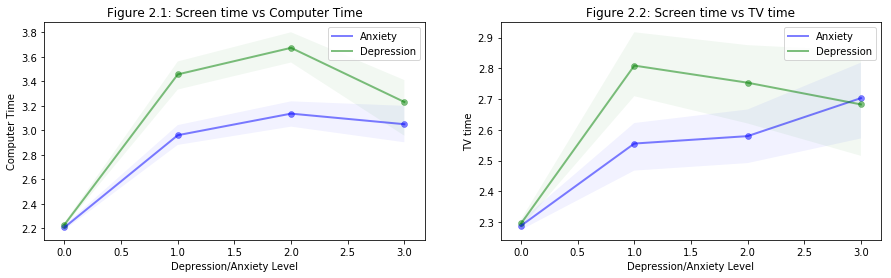

In [25]:
variables = ['cmputr_time', 'tv_time']
labels = ['Computer Time', 'TV time']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculateMeans(GroupToBins(df, group_name='anxiety_lvl'), variable=variables[i])
    bins_tv, perc_tv = CalculateMeans(GroupToBins(df, group_name='depression_lvl'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='anxiety_lvl', Operation=CalculateMeans, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='depression_lvl', Operation=CalculateMeans, variable=variables[i]))
    # Computer time
    ax[i].plot(bins, perc, label='Anxiety', linewidth=2, color='blue', alpha=0.5)
    ax[i].scatter(bins, perc, linewidth=0.5, color='blue', alpha=0.5)
    ax[i].fill_between(bins, cis[0], cis[1], where=cis[0] <= cis[1], 
                    facecolor='blue', alpha=0.05, interpolate=True)
    # TV time
    ax[i].plot(bins_tv, perc_tv, label='Depression', linewidth=2, color='green', alpha=0.5)
    ax[i].scatter(bins_tv, perc_tv, linewidth=0.5, color='green', alpha=0.5)
    ax[i].fill_between(bins, cis_tv[0], cis_tv[1], where=cis_tv[0] <= cis_tv[1], 
                    facecolor='green', alpha=0.05, interpolate=True)
    ax[i].legend(loc='best')
    ax[i].title.set_text("Figure 2." + str(i + 1) +": Screen time vs " + labels[i])
    ax[i].set(xlabel='Depression/Anxiety Level', ylabel=labels[i])

In [30]:
df[df['anxiety_lvl'] > 0].groupby('anxiety_lvl')['cmputr_time'].describe()

,count,mean,std,min,25%,50%,75%,max
anxiety_lvl,,,,,,,,
1.0,837.0,2.959379,1.465153,0.0,2.0,3.0,4.0,5.0
2.0,744.0,3.135753,1.497997,0.0,2.0,3.0,5.0,5.0
3.0,167.0,3.197605,1.583954,0.0,2.0,3.0,5.0,5.0


I didn't expect these plots to behave like that at first. It seems like there is no apparent relationship between screen time and anxiety/depression levels. What made me more confused was that kids having zero screen time even have more severe anxiety/depression! There is a seemingly linear trend on the left plot from screen time level 1 to 5, but the lines on the right graph are hard to tell whether there is a relationship between these variables.

However, when I looked closely at the data, I realized that we don't have enough datapoints to determine whether there is a relationship. The 90% CI gap is too big and suggests that there are a lot of uncertainties in these graphs.

One thing we can say when looking at the graphs is that, in general, the severity is between mild and moderate. However, this conclusion is not very useful and may be misleading because it suggests that screen time has something to do with anxiety/depression levels. Therefore, it's safe not to conclude anything at all.

In [18]:
df[df['anxiety_lvl'] > 0].groupby('cmputr_time')['anxiety_lvl'].describe()

,count,mean,std,min,25%,50%,75%,max
cmputr_time,,,,,,,,
0.0,82.0,1.670732,0.703692,1.0,1.0,2.0,2.0,3.0
1.0,214.0,1.570093,0.629660,1.0,1.0,1.0,2.0,3.0
2.0,344.0,1.546512,0.646263,1.0,1.0,1.0,2.0,3.0
3.0,412.0,1.594660,0.645607,1.0,1.0,2.0,2.0,3.0
4.0,274.0,1.627737,0.634852,1.0,1.0,2.0,2.0,3.0
5.0,422.0,1.701422,0.675986,1.0,1.0,2.0,2.0,3.0


In [19]:
df[df['depression_lvl'] > 0].groupby('cmputr_time')['depression_lvl'].describe()

,count,mean,std,min,25%,50%,75%,max
cmputr_time,,,,,,,,
0.0,28.0,1.714286,0.712697,1.0,1.0,2.0,2.0,3.0
1.0,52.0,1.519231,0.699871,1.0,1.0,1.0,2.0,3.0
2.0,91.0,1.428571,0.598941,1.0,1.0,1.0,2.0,3.0
3.0,170.0,1.523529,0.607672,1.0,1.0,1.0,2.0,3.0
4.0,150.0,1.526667,0.631358,1.0,1.0,1.0,2.0,3.0
5.0,281.0,1.658363,0.674015,1.0,1.0,2.0,2.0,3.0


***
### 3. Family meals vs Anxiety/Depression levels
Variables used: `family_meals`, `anxiety_lvl`, `depression_lvl`, `cmputr_time`

In this section, I added one more variable `family_meals` and visualize the relationships between:
- Family meals vs percentage of kids with anxiety
- Family meals vs percentage of kids with depression
- Family meals vs mean screen time (level)


Now, the bins are the frequencies of family meal **during the past week**, and were coded as follows:
- 0 = 0 days
- 1 = 1-3 days
- 2 = 4-6 days
- 3 = Every day

In [20]:
# Bins are the same for all
bins, perc_anxiety = CalculatePercentages(GroupToBins(df, group_name='family_meals'), variable='anxiety_lvl')
_, perc_depression = CalculatePercentages(GroupToBins(df, group_name='family_meals'), variable='depression_lvl')
_, screen_time = CalculateMeans(GroupToBins(df, group_name='family_meals'), variable='cmputr_time')

# Compute 90% CIs for each of them
cis_anxiety = ComputeCIs(SamplingDistributions(df, group_name='family_meals', Operation=CalculatePercentages, variable='anxiety_lvl'))
cis_depression = ComputeCIs(SamplingDistributions(df, group_name='family_meals', Operation=CalculatePercentages, variable='depression_lvl'))
cis_screen_time = ComputeCIs(SamplingDistributions(df, group_name='family_meals', Operation=CalculateMeans, variable='cmputr_time'))

The mean screen time level has a slightly different range compared to the percentages. To visualize these variables on the same plot, I used a two-scale plot: the left vertical axis corresponds to anxiety/depression levels while the right axis is for screen time. 

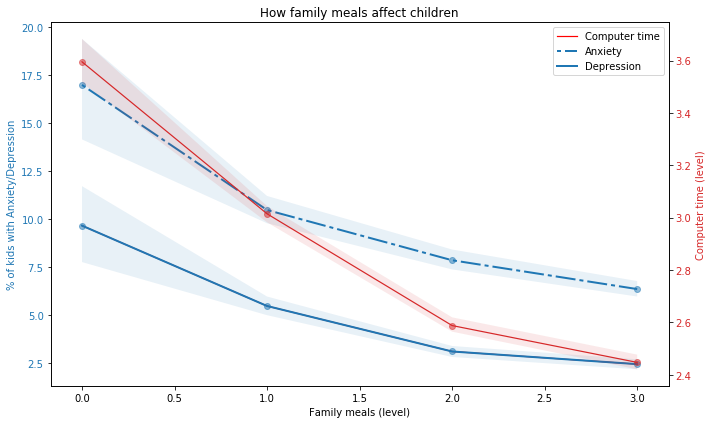

In [21]:
fig, ax2 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax2.set_xlabel('Family meals (level)')
ax2.set_ylabel('% of kids with Anxiety/Depression', color=color)  # we already handled the x-label with ax1
ax2.plot(bins, perc_depression, label='Computer time', linewidth=1.2, color='red', alpha=1) # Cheating a bit. Creating legend for computer time

# Anxiety plot
line, = ax2.plot(bins, perc_anxiety, label='Anxiety', linewidth=2, color=color)
line.set_dashes([2, 2, 10, 2])
ax2.scatter(bins, perc_anxiety, linewidth=1, color=color, alpha=0.5)
ax2.fill_between(bins, cis_anxiety[0], cis_anxiety[1], where=cis_anxiety[0] <= cis_anxiety[1], 
                    facecolor=color, alpha=0.1, interpolate=True)
# Depression plot
ax2.plot(bins, perc_depression, label='Depression', linewidth=2, color=color)
ax2.scatter(bins, perc_depression, linewidth=1, color=color, alpha=0.5)
ax2.fill_between(bins, cis_depression[0], cis_depression[1], where=cis_depression[0] <= cis_depression[1], 
                    facecolor=color, alpha=0.1, interpolate=True)
ax2.tick_params(axis='y', labelcolor=color)

ax1 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax1.set_ylabel('Computer time (level)', color=color)

# Computer time plot
ax1.plot(bins, screen_time, label='Computer time', linewidth=1.2, color=color)
ax1.scatter(bins, screen_time, linewidth=1, color=color, alpha=0.5)
ax1.fill_between(bins, cis_screen_time[0], cis_screen_time[1], where=cis_screen_time[0] <= cis_screen_time[1], 
                    facecolor=color, alpha=0.1, interpolate=True)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('How family meals affect children')

ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Interestingly, this graph suggests the strong linear relationships between anxiety/depression level and family meals as well as between computer time usage and family meals. Kids in families having more meals together tend to have less severe anxiety/depression, and they also tend to use computers less. It's also worth noting that more than 16% of kids having no meals with their families during the past week experience anxiety problems, while only 8% of kids having meals everyday with their families have an anxiety. However, we should also be cautious because the Confidence Intervals on the left tails of the 3 plots are much wider than the other end.

## Intepretation

This notebook has shown some interesting results from the NSCH 2017:
- First, for kids spending 4 hours or more with computers, about 16% of them have some anxiety problems, and 12% of them experience depression recently. 
- Second, children who spend 3 hours or more daily using computers are twice more likely to have an anxiety problem and four times more likely to experience depression. The P-values of both effects are small enough to conclude that they are statistically significant. 
- However, when we look at the plots of anxiety/depression severity versus screen time usage, we could not find any apparent relationship between the screen time and the severity level. It might be due to the small size of our data, which creates a high uncertainty in these plots, as evidenced by the wide ranges of Confidence Intervals.
- Also, how frequently a family having meals together has strong linear relationships with both their children's screen time and percentage of kids having anxiety/depression problems.
- Finally, even though we did show linear relationships between various variables, we're still not be able to conclude the direction of influence. As stated in the beginning, whether screen time affects children's wellbeing or vice versa is still a question. 